# **A/B Tests**

Imagine you are responsible for a service, say a website for pet adoption. You care about people booking a meeting to come visit and possibly adopt a stray. You have social-media outreach and key-word advertising to drive traffic, and you care specifically about the **conversion rate**: among the visitors who land on the home page, how many book a meeting.

To improve that conversion rate, you have an idea for an improvement: a cleaner page design or a more compelling call-to-action. You are not sure how effective it will be. The best way to do that is to **split** customers in two and show one half your existing set-up ('Control' or A) and the other half your modified, hopefully improved version ('Treatement', or B). If the improved version leads to a clearly better conversion, you probably want to adopt it.

It compares the two using a $t$-test to decide whether the observed difference is large enough to be meaningful, what we call **statistically significant**.

Spliting the traffic to an on-line service and comparing conversion rates with a $t$-test is a univerally used approach to understand the impact of any change. In science, it’s known as a **random control trial** (RCT) but online services prefer to call it an **A/B-test**.


In A/B testing, two versions of the same marketing material are created: version A (the control group) and version B (the treatment group). The two versions are then randomly shown to different groups of users, and their responses are measured and compared.

In A/B testing, the treatment group is the group that receives the modified version of the marketing material being tested (version B), while the control group is the group that receives the original or existing version of the marketing material (version A).

The purpose of the control group is to establish a baseline or benchmark against which the performance of the treatment group can be measured. By measuring the performance of both groups, analysts can determine whether the changes made in the treatment group had a statistically significant impact on the measured response metrics.



## **T-Test**

A t-test is a statistical test used to determine if there is a significant difference between the response metrics of the treatment group and the control group. It helps in evaluating whether the observed difference in performance between the two groups is statistically significant or simply due to random chance.

There are two common types of t-tests used in A/B testing: the independent samples t-test and the paired samples t-test.

Independent samples t-test: This type of t-test is used when the treatment and control groups are independent of each other, meaning that each participant is assigned to either the treatment or control group, but not both. The independent samples t-test compares the means of the response metrics between the two groups. It assumes that the response metrics are normally distributed and have equal variances.

Paired samples t-test: This type of t-test is used when the treatment and control groups are dependent on each other. It is employed when each participant is exposed to both the treatment and control conditions, such as in a before-and-after scenario. The paired samples t-test compares the mean differences between the response metrics of the two conditions. It also assumes that the differences are normally distributed.

In both types of t-tests, the null hypothesis assumes that there is no significant difference between the response metrics of the treatment and control groups. The alternative hypothesis suggests that there is a significant difference. By calculating the t-statistic and comparing it to the critical value from the t-distribution, a p-value is obtained. If the p-value is below a predetermined significance level (typically 0.05), the null hypothesis is rejected, indicating a statistically significant difference between the groups.

T-tests provide a statistical framework to assess the significance of the observed differences in response metrics between the treatment and control groups, helping to determine the effectiveness of the changes made in the A/B test.

# 1. Import 
## Key libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
plt.style.use('dark_background')



## Event log data from a pickle file


In [2]:
events_df = pd.read_pickle('../data/events.pkl')

# 2. Data processing 
## Aggregate into conversion rates

In [3]:
def aggregate(events_df):
    total_users = events_df\
        .groupby(['variant'])\
        ['user_domain_id'].nunique()
    conversion_count = events_df\
        .groupby(['variant', 'page_url_path'])\
        ['user_domain_id'].nunique()
    conversion_rate = pd.DataFrame(conversion_count)\
        .join(total_users, on='variant', rsuffix='_total')
    conversion_rate['conversion_rate'] =       \
        conversion_rate['user_domain_id'] /    \
        conversion_rate['user_domain_id_total']
    conversion_rate.drop(
        columns=['user_domain_id'], inplace=True)
    conversion_rate.columns = \
        ['visitors', 'conversion_rate']
    conversion_rate = conversion_rate\
    .pivot_table(
        index='page_url_path',
        columns='variant',
        values=['visitors', 'conversion_rate']) \
    .sort_values(
        ('conversion_rate', 'Treatment'),
        ascending=False
    )
    return conversion_rate

In [4]:
aggregate(events_df)


conversion_rate           visitors          
variant               Control Treatment  Control Treatment
page_url_path                                             
/home                0.876923  0.803030       65        66
/product_a           0.476923  0.515152       65        66
/product_b           0.323077  0.303030       65        66
/cart                0.246154  0.136364       65        66
/confirmation        0.138462  0.060606       65        66
/payment             0.138462  0.060606       65        66

## Compute t-test statistics

In [5]:
from scipy.stats import t
alpha = 0.05

def compute_t_test(c):    
    c['difference'] =                               \
        c['conversion_rate']['Treatment'] -         \
        c['conversion_rate']['Control']
    c['stdev'] = (
            c['conversion_rate']['Treatment'] *     \
            (1 - c['conversion_rate']['Treatment'])/
                c['visitors']['Treatment'] +  
            c['conversion_rate']['Control'] *       \
            (1 - c['conversion_rate']['Control'])/
                c['visitors']['Control']
        ) ** 0.5
    c['t-score'] = c['difference'] / c['stdev']
    c['degrees_freedom'] =                          \
        c['visitors']['Control'] +                  \
        c['visitors']['Treatment'] - 1
    c['p-value'] = t.sf(
        np.abs(c['t-score']),
        c['degrees_freedom']
    ) * 2
    c['minimum_detectable_effect'] =                \
        t.ppf(1 - alpha/2, c['degrees_freedom']) *  \
        c['stdev']
    c['significant'] = c['p-value'] < alpha
 
    return c

# Results of the t-test

In [6]:
compute_t_test(aggregate(events_df))

conversion_rate           visitors           difference  \
variant               Control Treatment  Control Treatment              
page_url_path                                                           
/home                0.876923  0.803030       65        66  -0.073893   
/product_a           0.476923  0.515152       65        66   0.038228   
/product_b           0.323077  0.303030       65        66  -0.020047   
/cart                0.246154  0.136364       65        66  -0.109790   
/confirmation        0.138462  0.060606       65        66  -0.077855   
/payment             0.138462  0.060606       65        66  -0.077855   

                  stdev   t-score degrees_freedom   p-value  \
variant                                                       
page_url_path                                                 
/home          0.063695 -1.160111             130  0.248130   
/product_a     0.087306  0.437867             130  0.662210   
/product_b     0.081022 -0.247421             130  0.804973   
/cart          0.068111 -1.611919             130  0.109405   
/confirmation  0.051941 -1.498926             130  0.136317   
/payment       0.051941 -1.498926             130  0.136317   

              minimum_detectable_effect significant  
variant                                              
page_url_path                                        
/home                          0.126012       False  
/product_a                     0.172725       False  
/product_b                     0.160293       False  
/cart                          0.134750       False  
/confirmation                  0.102759       False  
/payment                       0.102759       False

## Permutation tests

What if we randomised the assignment?
Tested what it’s like to A/B test if there is no difference between the A and B?


#### **A/A Tests**
A/A tests, also known as control tests or baseline tests, are experimental designs used in the field of statistics and experimentation. The purpose of an A/A test is to validate the reliability and consistency of the testing infrastructure or measurement system before conducting more advanced experiments like A/B tests.

In an A/A test, two identical or nearly identical groups, referred to as the control groups, are created. These groups are exposed to the exact same conditions, experiences, or treatments, with no intentional differences or variations introduced. The only purpose of an A/A test is to check if the measurement system is functioning correctly and to identify any sources of bias or inconsistency.

The key objectives and benefits of conducting A/A tests are as follows:

Validating the Measurement System: A/A tests help in assessing the accuracy and reliability of the measurement system or testing infrastructure being used. By comparing the results from the two identical groups, any inconsistencies or issues in data collection, tracking, or analysis can be identified.

Identifying Sources of Variability: A/A tests are valuable for identifying potential sources of variability that could affect the results of subsequent experiments. By running the same experiment in parallel, it becomes easier to differentiate between genuine treatment effects and random fluctuations.

Evaluating Statistical Significance: A/A tests provide a baseline to evaluate statistical significance in subsequent experiments like A/B tests. By comparing the results of the A/A test groups, it helps to set realistic expectations for effect sizes and confidence intervals.

Building Confidence: By ensuring that the testing infrastructure is robust and the results are consistent, A/A tests build confidence in the experimental process and increase trust in subsequent experiments.

In [7]:
from random import choices
from tqdm import tqdm

_events_ = events_df.copy()
users = pd.DataFrame(
    events_df['user_domain_id'].unique(), columns=['user_domain_id']
)

In [8]:
users

,user_domain_id
0,65669b97-1065-43b5-9892-e477335175c6
1,ef2f545f-4650-42d4-9067-ccf1268218df
2,3c55d34d-3948-4f89-bd24-12e17da22108
3,b57a9c82-4198-4524-9be9-a4a1b7938bfb
4,4ef751f3-7e42-4ef0-a1fa-136de4f01852
...,...
126,fe974774-c496-490a-b676-31ac700abda9
127,7354b59c-6163-4dcb-a910-0301c22c6f10
128,7b807d30-c991-449f-b061-a673c3fe1073
129,b0d12a66-0015-41d8-99f6-5b916ca969e7


## Permutation

In [9]:
def permutation_test(_events_, n=30):
    results = []
    #for _ in tqdm(range(n)):
    for _ in range(n):
        users['variant'] = choices(['Control', 'Treatment'], k=len(users))
        try:
            _events_.drop(columns=['variant'], inplace=True)
        except:
            pass
        _events_ = _events_.merge(users, on='user_domain_id')
        result = compute_t_test(aggregate(_events_))
        results.append(result)        
    return results

In [10]:
results = permutation_test(_events_, n=1000)
len(results)


1000

In [11]:
relevant = pd.concat(results)[["difference", "significant"]].loc['/confirmation']
relevant

,difference,significant
variant,,
page_url_path,,
/confirmation,0.010669,False
/confirmation,-0.090398,False
/confirmation,-0.044289,False
/confirmation,0.050373,False
/confirmation,0.007558,False
...,...,...
/confirmation,-0.023382,False
/confirmation,-0.008224,False


## Summary results

In [12]:
def aggregate(relevant):
    return relevant.agg(['mean', 'std', 'count']).T\
        .style.format({
            'mean': lambda x: '{:,.2%}'.format(x) if x < 0.01 else '{:,.0%}'.format(x),
            'std': lambda x: '{:,.2%}'.format(x) if x < 0.01 else '{:,.0%}'.format(x),
            'count': '{:,.0f}'.format,
        })

In [13]:
aggregate(relevant)

,,mean,std,count
,variant,,,
difference,,-0.09%,5%,"1,000"
significant,,5%,21%,"1,000"


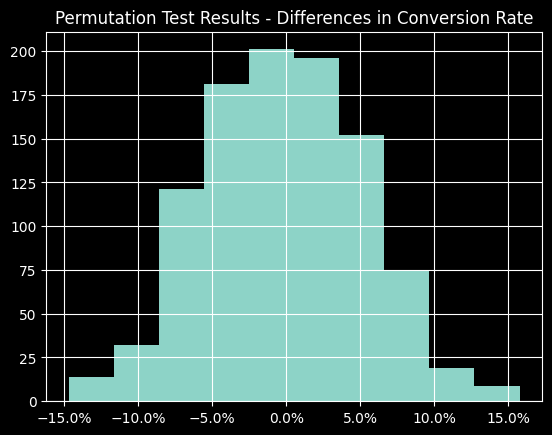

In [14]:
relevant.hist()
plt.title('Permutation Test Results - Differences in Conversion Rate')
plt.gca().xaxis.set_major_formatter(PercentFormatter(1, decimals=None))



## Interview Questions



* What is A/B testing, and why is it commonly used in data-driven decision-making?

* What is the difference between the treatment group and the control group in an A/B test?

* How do you determine the sample size for an A/B test? What factors influence this decision?


* What is hypothesis testing, and how does it apply to A/B testing?

* What is the p-value in A/B testing, and how do you interpret its significance?

* What are Type I and Type II errors in A/B testing, and how do they relate to statistical significance and statistical power?

